In [1]:
from __future__ import division
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from loader import *
import glob
import numpy as np
import copy
import yaml
from sklearn.metrics import f1_score
from tqdm import tqdm
from model.TransMUNet import TransMUNet
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.ndimage.morphology import binary_fill_holes, binary_opening

In [2]:
## Hyper parameters
config         = yaml.load(open('./config_skin.yml'), Loader=yaml.FullLoader)
number_classes = int(config['number_classes'])
input_channels = 3
best_val_loss  = np.inf
patience       = 0
device = 'cuda' if torch.cuda.is_available() else 'cpu'

data_path = config['path_to_data']

test_dataset = isic_loader(path_Data = data_path, train = False, Test = True)
test_loader  = DataLoader(test_dataset, batch_size = 1, shuffle= True)


In [3]:
Net = TransMUNet(n_classes = number_classes)
Net = Net.to(device)
Net.load_state_dict(torch.load(config['saved_model'], map_location='cpu')['model_weights'])


<All keys matched successfully>

## Quntitative performance

In [4]:
predictions = []
gt = []

with torch.no_grad():
    print('val_mode')
    val_loss = 0
    Net.eval()
    for itter, batch in tqdm(enumerate(test_loader)):
        img = batch['image'].to(device, dtype=torch.float)
        msk = batch['mask']
        msk_pred = Net(img)

        gt.append(msk.numpy()[0, 0])
        msk_pred = msk_pred.cpu().detach().numpy()[0, 0]
        msk_pred  = np.where(msk_pred>=0.43, 1, 0)
        msk_pred = binary_opening(msk_pred, structure=np.ones((6,6))).astype(msk_pred.dtype)
        msk_pred = binary_fill_holes(msk_pred, structure=np.ones((6,6))).astype(msk_pred.dtype)
        predictions.append(msk_pred)        
        
        
        
predictions = np.array(predictions)
gt = np.array(gt)

y_scores = predictions.reshape(-1)
y_true   = gt.reshape(-1)

y_scores2 = np.where(y_scores>0.47, 1, 0)
y_true2   = np.where(y_true>0.5, 1, 0)

#F1 score
F1_score = f1_score(y_true2, y_scores2, labels=None, average='binary', sample_weight=None)
print ("\nF1 score (F-measure) or DSC: " +str(F1_score))
confusion = confusion_matrix(np.int32(y_true), y_scores2)
print (confusion)
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print ("Accuracy: " +str(accuracy))
specificity = 0
if float(confusion[0,0]+confusion[0,1])!=0:
    specificity = float(confusion[0,0])/float(confusion[0,0]+confusion[0,1])
print ("Specificity: " +str(specificity))
sensitivity = 0
if float(confusion[1,1]+confusion[1,0])!=0:
    sensitivity = float(confusion[1,1])/float(confusion[1,1]+confusion[1,0])
print ("Sensitivity: " +str(sensitivity))




val_mode


520it [00:40, 12.96it/s]



F1 score (F-measure) or DSC: 0.905959927423948
[[26482720   733619]
 [  633762  6228619]]
Accuracy: 0.9598758110633263
Specificity: 0.973044905121148
Sensitivity: 0.907646923130616


## Visualization section

In [5]:
def save_sample(img, msk, msk_pred, th=0.3, name=''):
    img2 = img.detach().cpu().numpy()[0]
    img2 = np.einsum('kij->ijk', img2)
    msk2 = msk.detach().cpu().numpy()[0,0]
    mskp = msk_pred.detach().cpu().numpy()[0,0]
    msk2 = np.where(msk2>0.5, 1., 0)
    mskp = np.where(mskp>=th, 1., 0)

    plt.figure(figsize=(7,15))

    plt.subplot(3,1,1)
    plt.imshow(img2/255.)
    plt.axis('off')

    plt.subplot(3,1,2)
    plt.imshow(msk2*255, cmap= 'gray')
    plt.axis('off')

    plt.subplot(3,1,3)
    plt.imshow(mskp*255, cmap = 'gray')
    plt.axis('off')

    plt.savefig('./results/'+name+'.png')


val_mode


4it [00:01,  3.79it/s]


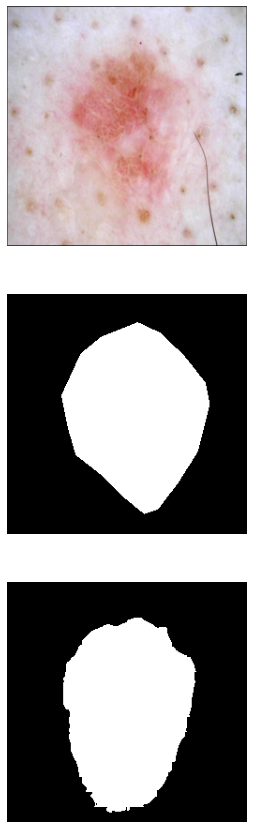

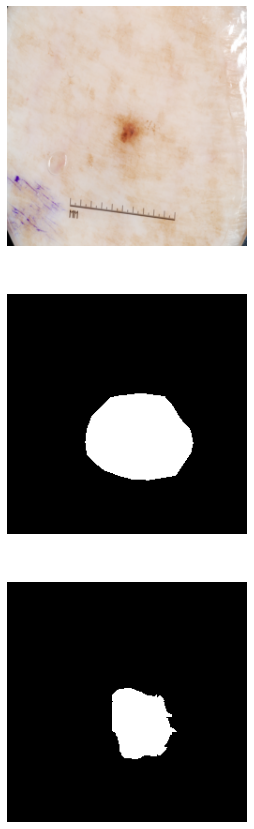

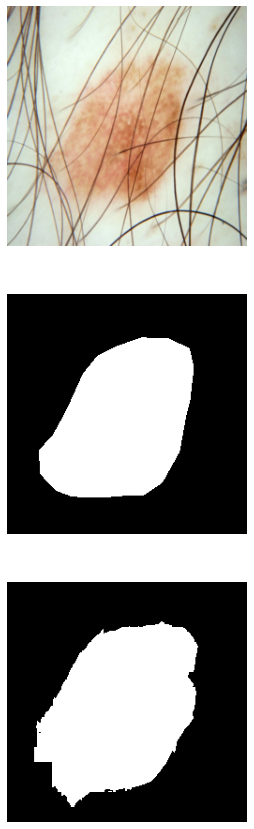

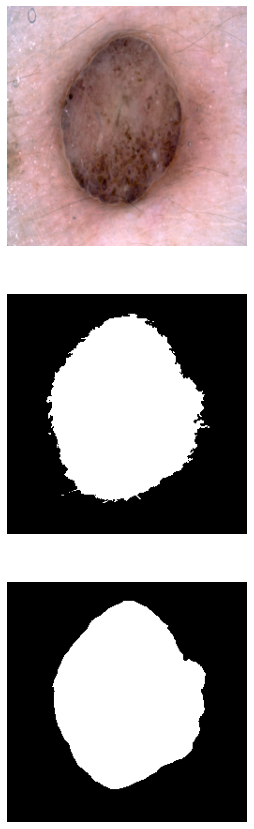

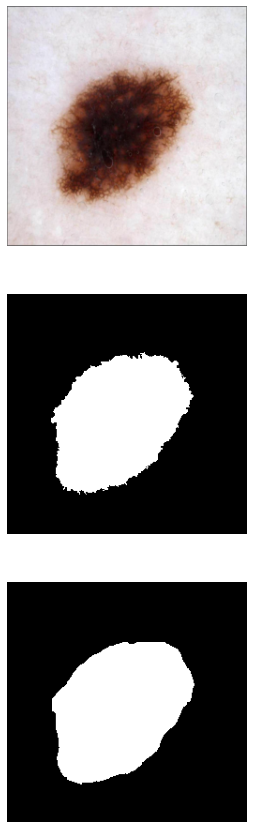

In [6]:
predictions = []
gt = []

N = 5 ## Number of samples to visualize
with torch.no_grad():
    print('val_mode')
    val_loss = 0
    Net.eval()
    for itter, batch in tqdm(enumerate(test_loader)):
        img = batch['image'].to(device, dtype=torch.float)
        msk = batch['mask']
        msk_pred = Net(img)
        
        gt.append(msk.numpy())
        predictions.append(msk_pred.cpu().detach().numpy())
        save_sample(img, msk, msk_pred, th=0.5, name=str(itter+1))
        if itter+1==N:
            break
            